In [3]:
import warnings
warnings.simplefilter('ignore')


## Import relevant libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [5]:
# read the data
df = pd.read_csv('/content/gdrive/MyDrive/machine learning/hourly/PJME_hourly.csv')

In [6]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [7]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [8]:
df = df.set_index('Datetime')

In [9]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [10]:
df.index = pd.to_datetime(df.index)

<Axes: xlabel='Datetime'>

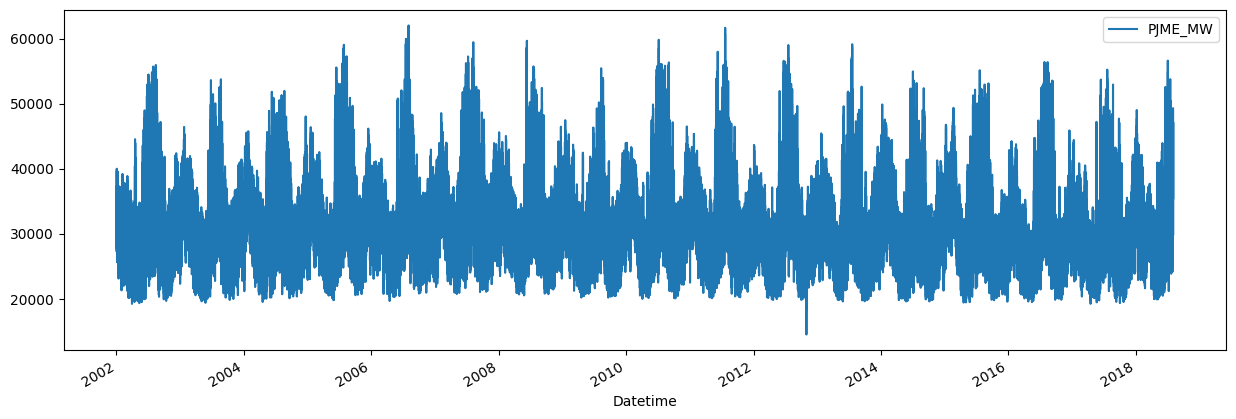

In [11]:
df.plot(figsize=(15,5))

## Train/test Split

In [12]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

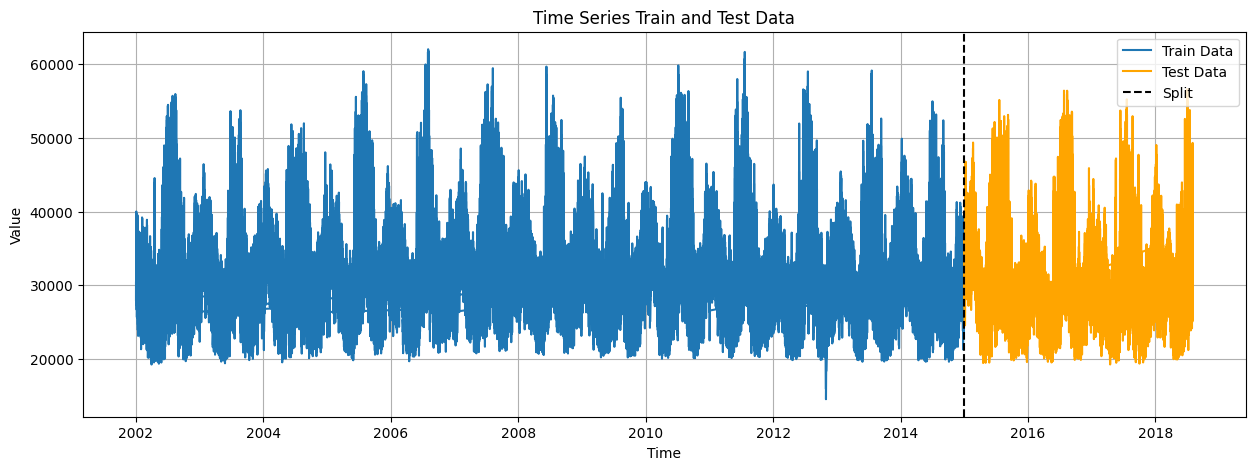

In [13]:
plt.figure(figsize=(15, 5))
plt.plot(train.index, train.values, label='Train Data')
plt.plot(test.index, test.values, label='Test Data', color='orange')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Train and Test Data')
split_index = test.index[0]
# Add a vertical line at the split point
plt.axvline(split_index, color='black', linestyle='--', label='Split')
plt.legend()
plt.grid(True)
plt.show()

<Axes: title={'center': 'Week of the data'}, xlabel='Datetime'>

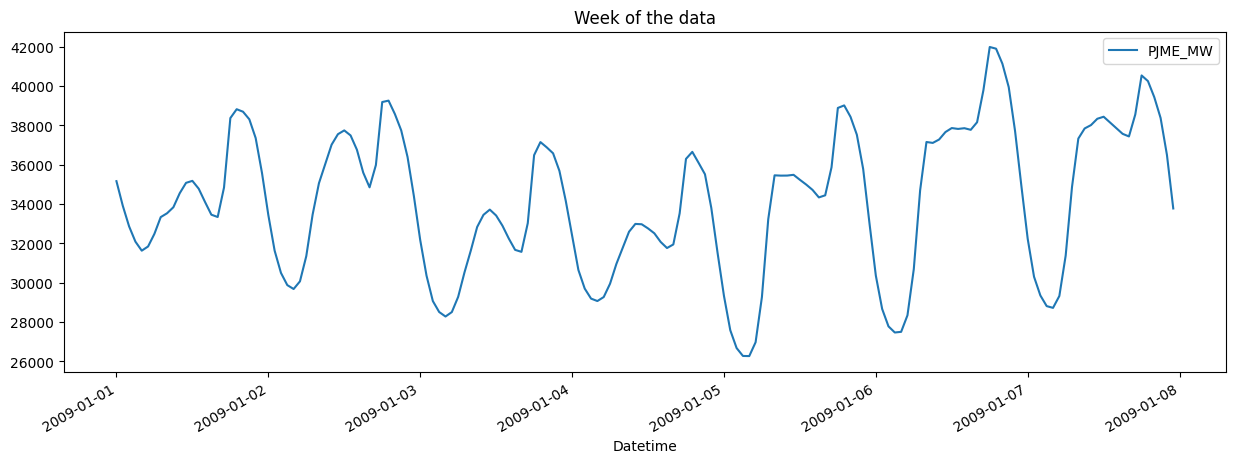

In [14]:
# Plot a week of data
df.loc[(df.index >= '01-01-2009') & (df.index < '01-08-2009')].plot(figsize=(15,5), title ='Week of the data')

## Feature creation

In [28]:
def create_time_series_features(data):
    """
    Function to create time-based features for time series data.

    Parameters:
        data (pd.DataFrame or pd.Series): Time series data with a time-based index.

    Returns:
        pd.DataFrame: A DataFrame containing original data and additional time-based features.
    """
    # Ensure data is a DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)

    # Copy original data
    df = data.copy()

    # Extract time-based features from the index
    df['year'] = data.index.year
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['quarter'] = df.index.quarter
    df['weekday'] = data.index.weekday  # Monday=0, Sunday=6
    df['yearday'] = df.index.dayofyear
    df['monthday'] = df.index.day
    df['hour'] = data.index.hour
    df['minute'] = data.index.minute
    df['second'] = data.index.second

    return df



In [29]:
data = create_time_series_features(df)

Text(0.5, 1.0, 'MW by Hour')

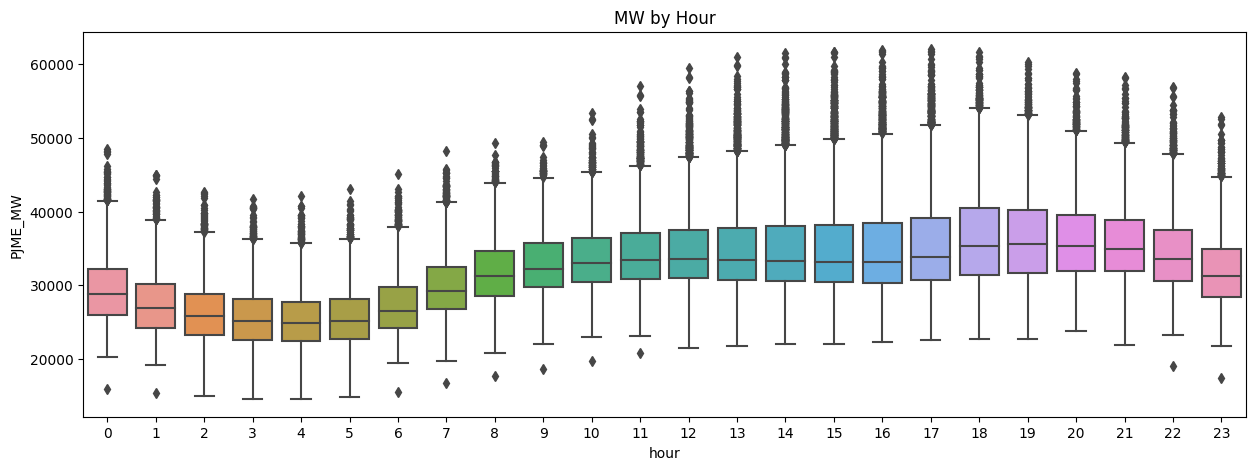

In [30]:
fig, ax= plt.subplots(figsize=(15,5))
sns.boxplot(data = data, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')

Text(0.5, 1.0, 'MW by Month')

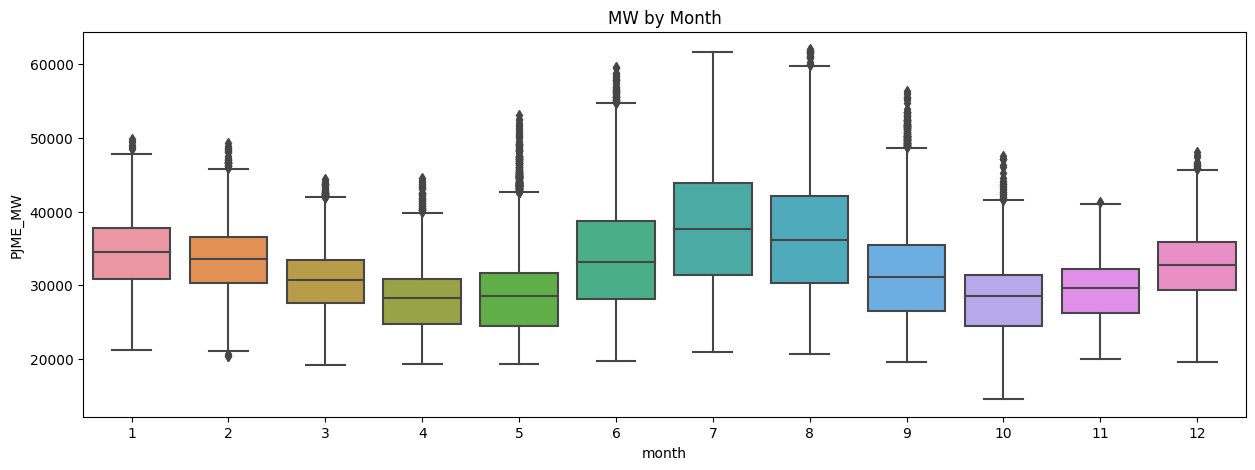

In [31]:
fig, ax= plt.subplots(figsize=(15,5))
sns.boxplot(data = data, x = 'month', y = 'PJME_MW')
ax.set_title('MW by Month')

## Create a the Model

In [32]:
data.columns.tolist()

['PJME_MW',
 'year',
 'month',
 'day',
 'quarter',
 'weekday',
 'yearday',
 'monthday',
 'hour',
 'minute',
 'second']

In [33]:
train = create_time_series_features(train)
test = create_time_series_features(test)

FEATURES = ['year',
 'month',
 'day',
 'quarter',
 'weekday',
 'yearday',
 'monthday',
 'hour',
 'minute',
 'second']

TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [34]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[22:06:49] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32605.13860	validation_1-rmse:31657.15907
[100]	validation_0-rmse:12581.21569	validation_1-rmse:11743.75114
[200]	validation_0-rmse:5835.12159	validation_1-rmse:5365.57218
[300]	validation_0-rmse:3916.12255	validation_1-rmse:4020.51855
[400]	validation_0-rmse:3443.81721	validation_1-rmse:3860.34291
[500]	validation_0-rmse:3284.48321	validation_1-rmse:3809.80766
[600]	validation_0-rmse:3201.62999	validation_1-rmse:3777.53737
[700]	validation_0-rmse:3149.50572	validation_1-rmse:3753.76203
[800]	validation_0-rmse:3110.02432	validation_1-rmse:3737.82706
[900]	validation_0-rmse:3079.66276	validation_1-rmse:3727.50121
[999]	validation_0-rmse:3051.57992	validation_1-rmse:3723.13596


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

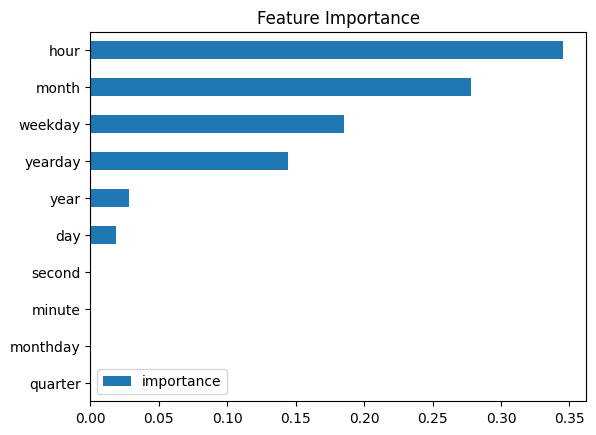

In [35]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forcast on the test data

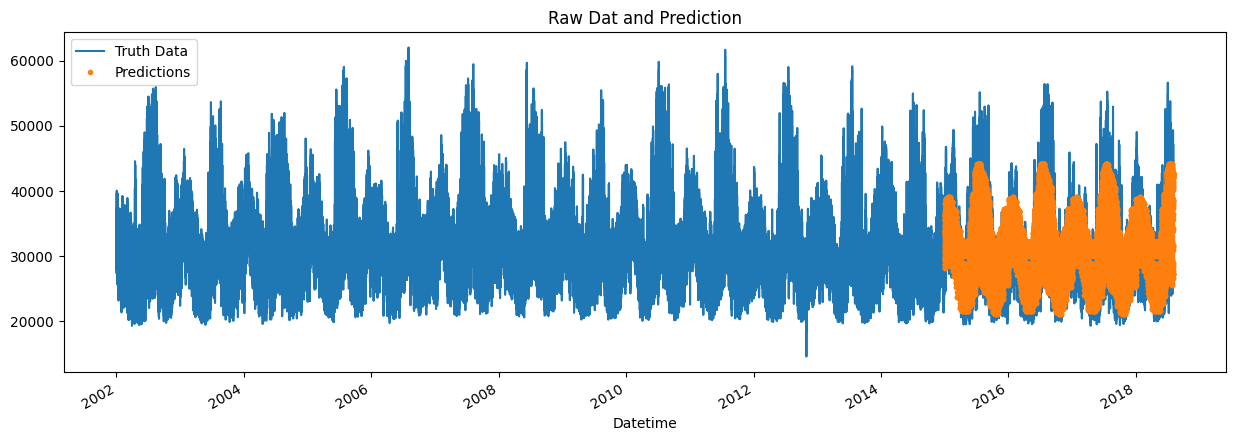

In [40]:
test['prediction'] = reg.predict(X_test)
data = data.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
data['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

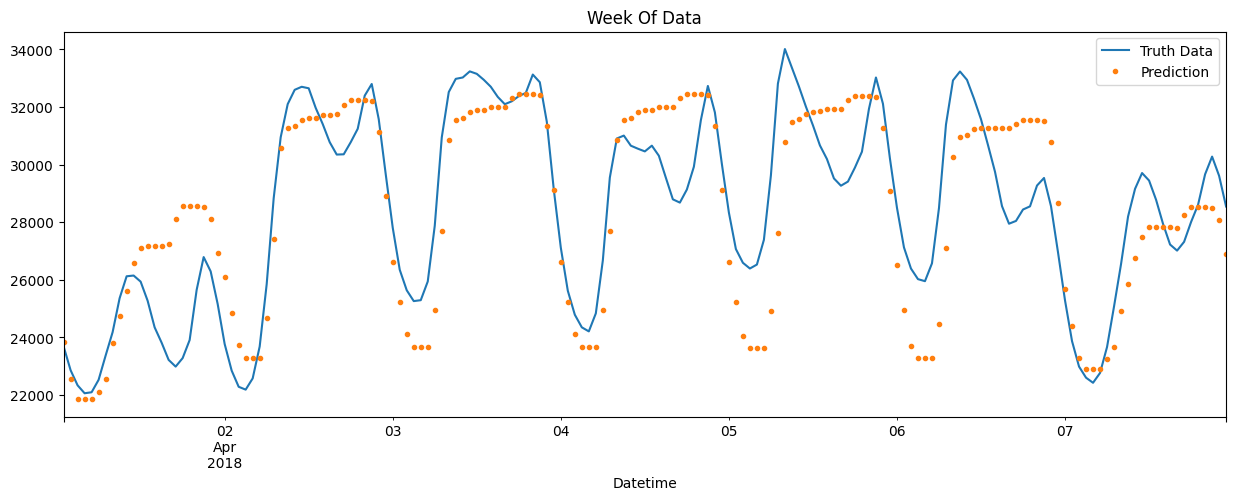

In [44]:
ax = data.loc[(data.index > '04-01-2018') & (data.index < '04-08-2018')]['PJME_MW'].plot(figsize=(15, 5), title='Week Of Data')
data.loc[(data.index > '04-01-2018') & (data.index < '04-08-2018')]['prediction'].plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Score

In [45]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3722.68
